# Trying background subtraction # 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.morphology import skeletonize
from scipy.ndimage import label

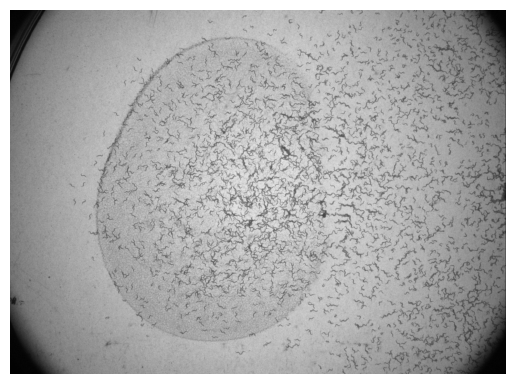

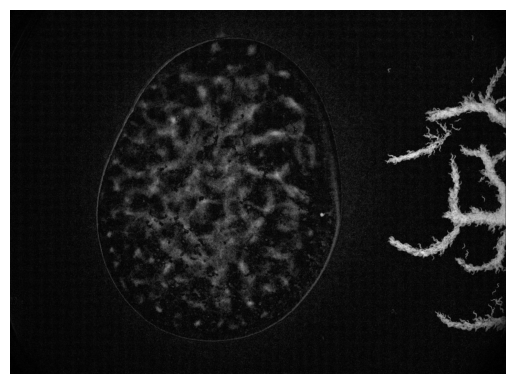

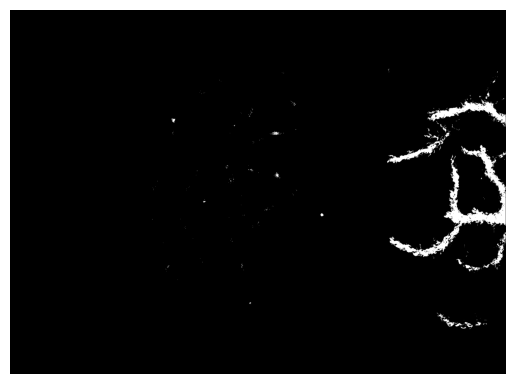

(1504, 2048)

In [8]:
# Specify the directory where the frames are stored
frame_dir = '/Volumes/TOSHIBA_EXT/swarming_surabhi/Experiment-584'
frame_files = [os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith('.jpg') and not f.startswith('._')]

k = 4

# Check if frame_files is not empty
if not frame_files:
    raise ValueError("No frame files found in the specified directory.")

# Sample n images across the video
n = min(50, len(frame_files))  # Use 50 or the number of available frames, whichever is smaller
sampled_frames = np.linspace(0, len(frame_files) - 1, n, dtype=int)

# Load the sampled frames
background_frames = []
for i in sampled_frames:
    img = cv2.imread(frame_files[i], cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise IOError(f"Could not load image {frame_files[i]}")
    background_frames.append(img)

# Check that all images have the same shape
if not all(img.shape == background_frames[k].shape for img in background_frames):
    raise ValueError("Not all images have the same shape.")


# Compute the average of the sampled frames
background_avg = np.mean(background_frames, axis=0).astype(np.uint8)

# Subtract the background from one of the frames for visualization
frame_to_subtract = cv2.imread(frame_files[k], cv2.IMREAD_GRAYSCALE)
background_subtracted = cv2.absdiff(frame_to_subtract, background_avg)

# Plot the frame with the lightest pixels
plt.imshow(background_frames[k], cmap='gray')
# plt.title('Lightest Pixels After Background Subtraction')
plt.axis('off')
plt.show()

# Plot the frame with the background subtracted
plt.imshow(background_subtracted, cmap='gray')
# plt.title('Frame with Background Subtracted')
plt.axis('off')
plt.show()

# Keep only the lightest valued pixels
# You can adjust the threshold value as needed
_, lightest_pixels = cv2.threshold(background_subtracted, 25, 255, cv2.THRESH_BINARY)

# Plot the frame with the lightest pixels
plt.imshow(lightest_pixels, cmap='gray')
# plt.title('Lightest Pixels After Background Subtraction')
plt.axis('off')
plt.show()

lightest_pixels.shape

## Apply to all frames and reconstruct video ## 

In [7]:
import cv2
import numpy as np
import os

# Create a directory for preprocessed frames if it does not exist
preprocessed_dir = '/Volumes/TOSHIBA_EXT/swarming_surabhi/Experiment-589/preprocessed_frames'
os.makedirs(preprocessed_dir, exist_ok=True)

# Process each frame
for frame_file in frame_files:
    frame = cv2.imread(frame_file, cv2.IMREAD_GRAYSCALE)
    if frame is None:
        raise IOError(f"Could not load image {frame_file}")

    # Subtract the background
    background_subtracted = cv2.absdiff(frame, background_avg)
    
    # Apply threshold
    _, thresholded_frame = cv2.threshold(background_subtracted, 32, 255, cv2.THRESH_BINARY)
    
    # Construct the path for the preprocessed frame
    preprocessed_frame_path = os.path.join(preprocessed_dir, os.path.basename(frame_file))
    
    # Save the thresholded frame
    cv2.imwrite(preprocessed_frame_path, thresholded_frame)

# Inform the user of completion
print(f"All frames have been processed and saved to {preprocessed_dir}.")

KeyboardInterrupt: 

In [8]:
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # You can change 'mp4v' with 'XVID' if you want to use .avi format
output_video_path = os.path.join(preprocessed_dir, 'processed_video.mp4') # Change extension to .avi if needed
frame_shape = (background_frames[0].shape[1], background_frames[0].shape[0])
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, frame_shape, isColor=False)

# Retrieve and sort the processed frames
processed_frames = [os.path.join(preprocessed_dir, f) for f in os.listdir(preprocessed_dir) if f.endswith('.tif')]
processed_frames.sort(key=lambda x: int(x.split('_t')[-1].split('.tif')[0]))

# Write frames to the video
for frame_path in processed_frames:
    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    out.write(frame)

# Release everything when job is finished
out.release()

# Inform the user of completion
print(f"The video has been created at {output_video_path}.")

The video has been created at /Volumes/TOSHIBA_EXT/swarming_surabhi/Experiment-589/preprocessed_frames/processed_video.mp4.


## Fit network to image ##

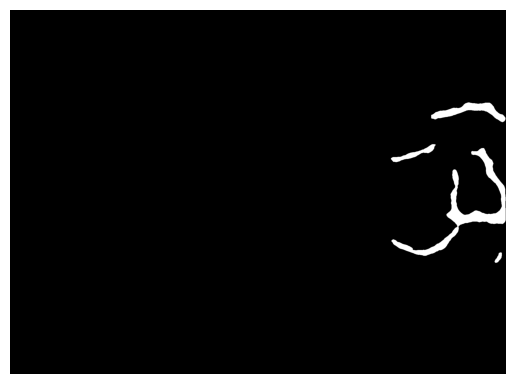

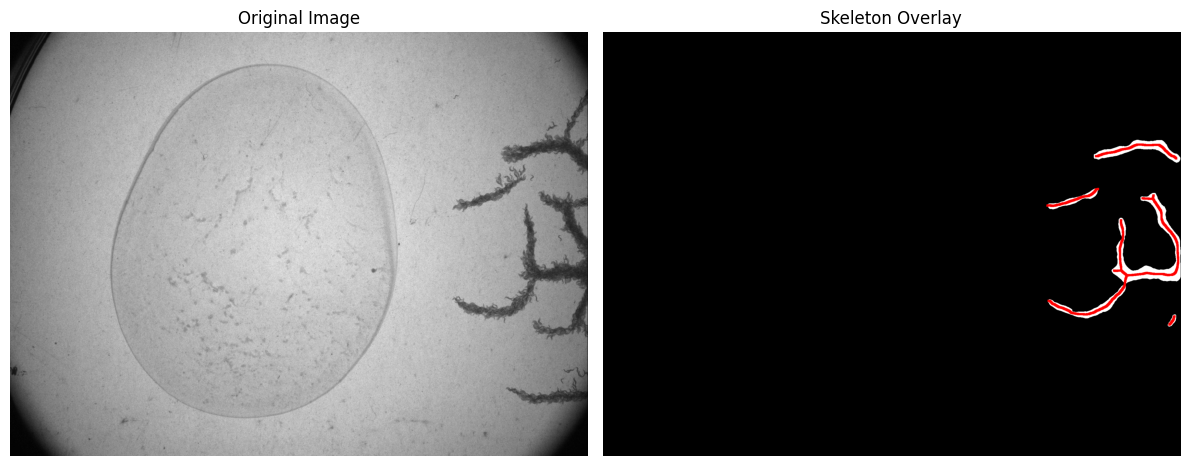

In [13]:
from skimage.morphology import dilation, square

# Apply Median Filter
# The argument to the function is the size of the kernel. Here it's set to 5.
median_smoothed_image = cv2.medianBlur(lightest_pixels, 29)

# Skeletonize the image to get the center line of white pixels
# Skeletonize the smoothed image
skeleton = skeletonize(median_smoothed_image // 255).astype(np.uint8)

# Increase the thickness of the skeleton
thick_skeleton = dilation(skeleton, square(8))  # Adjust the size for thicker lines as needed

# Convert the median smoothed image to BGR before overlaying the thick skeleton
thick_overlay_image = cv2.cvtColor(median_smoothed_image, cv2.COLOR_GRAY2BGR)
thick_overlay_image[thick_skeleton == 1] = [255, 0, 0]  # Red color for the skeleton

# Plot the frame with the lightest pixels
plt.imshow(median_smoothed_image, cmap='gray')
# plt.title('Smoothed Image')
plt.axis('off')
plt.show()

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(background_frames[0], cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(thick_overlay_image)
axes[1].set_title('Skeleton Overlay')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


## detect nodes and end nodes on the skeleton ##

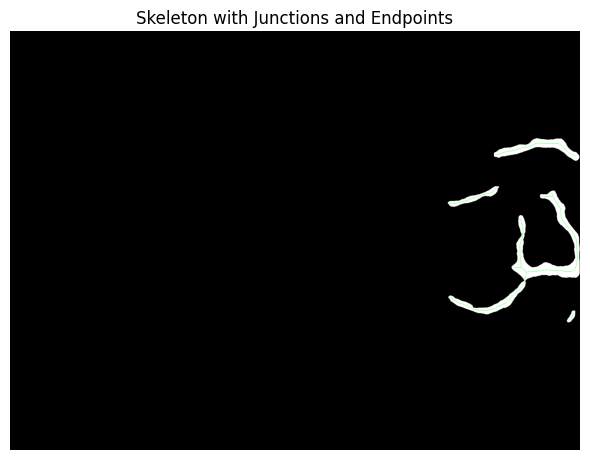

In [17]:
from skimage.morphology import skeletonize, dilation, square
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Now we proceed to detect junctions and endpoints in the skeleton
# Create a kernel for detecting the neighbors
# A pixel must be white and have exactly one white neighbor to be an endpoint
# A pixel must be white and have more than two white neighbors to be a junction
kernel = np.array([[1,  1, 1],
                   [1, 10, 1],
                   [1,  1, 1]], dtype=np.uint8)

# Filter the skeleton with the kernel
filtered = cv2.filter2D(skeleton, -1, kernel)

# Now, detect the junctions and endpoints based on the convoluted image
junctions = np.where(filtered > 11, 1, 0)
endpoints = np.where(filtered == 11, 1, 0)

# Increase the thickness of the skeleton for visualization purposes
thick_skeleton = dilation(skeleton, square(6))  # Adjust the size for thicker lines as needed

# Convert the median smoothed image to BGR before overlaying the skeleton
overlay_image = cv2.cvtColor(median_smoothed_image, cv2.COLOR_GRAY2BGR)
# overlay_image[thick_skeleton == 1] = [255, 0, 255]  # Red color for the skeleton
overlay_image[junctions == 1] = [0, 255, 0]  # Green color for junctions
# overlay_image[endpoints == 1] = [0, 0,255]  # Blue color for endpoints

# Display the images
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(overlay_image)
ax.set_title('Skeleton with Junctions and Endpoints')
ax.axis('off')
plt.tight_layout()
plt.show()
